##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multiclass classifier to predict the tag for a programming question on Stack Overflow.


In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [4]:
print(tf.__version__)

2.4.1


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [4]:
!pwd

/tf


In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 20s 0us/step


In [6]:
os.listdir(dataset_dir)

['test', 'imdb.vocab', 'README', 'train', 'imdbEr.txt']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'unsupBow.feat',
 'unsup',
 'urls_neg.txt',
 'neg',
 'urls_pos.txt',
 'urls_unsup.txt',
 'pos']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [13]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Note: The Preprocessing APIs used in the following section are experimental in TensorFlow 2.3 and subject to change.

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `preprocessing.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: to prevent [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also know as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. you will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create our neural network:

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, see the [word embedding tutorial](../text/word_embeddings.ipynb).
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


  1/625 [..............................] - ETA: 9:29 - loss: 0.6965 - binary_accuracy: 0.3750

 11/625 [..............................] - ETA: 3s - loss: 0.6939 - binary_accuracy: 0.4707  

 23/625 [>.............................] - ETA: 2s - loss: 0.6934 - binary_accuracy: 0.5014

 35/625 [>.............................] - ETA: 2s - loss: 0.6932 - binary_accuracy: 0.5095

 47/625 [=>............................] - ETA: 2s - loss: 0.6930 - binary_accuracy: 0.5136

 59/625 [=>............................] - ETA: 2s - loss: 0.6929 - binary_accuracy: 0.5169

 72/625 [==>...........................] - ETA: 2s - loss: 0.6928 - binary_accuracy: 0.5199

 85/625 [===>..........................] - ETA: 2s - loss: 0.6926 - binary_accuracy: 0.5224

 98/625 [===>..........................] - ETA: 2s - loss: 0.6925 - binary_accuracy: 0.5236

110/625 [====>.........................] - ETA: 2s - loss: 0.6924 - binary_accuracy: 0.5240

122/625 [====>.........................] - ETA: 2s - loss: 0.6923 - binary_accuracy: 0.5249

134/625 [=====>........................] - ETA: 2s - loss: 0.6921 - binary_accuracy: 0.5266

146/625 [======>.......................] - ETA: 2s - loss: 0.6920 - binary_accuracy: 0.5289

158/625 [======>.......................] - ETA: 2s - loss: 0.6919 - binary_accuracy: 0.5315

171/625 [=======>......................] - ETA: 1s - loss: 0.6918 - binary_accuracy: 0.5345

184/625 [=======>......................] - ETA: 1s - loss: 0.6916 - binary_accuracy: 0.5374

196/625 [========>.....................] - ETA: 1s - loss: 0.6915 - binary_accuracy: 0.5401

208/625 [========>.....................] - ETA: 1s - loss: 0.6913 - binary_accuracy: 0.5424

220/625 [=========>....................] - ETA: 1s - loss: 0.6912 - binary_accuracy: 0.5448

232/625 [==========>...................] - ETA: 1s - loss: 0.6911 - binary_accuracy: 0.5473

243/625 [==========>...................] - ETA: 1s - loss: 0.6909 - binary_accuracy: 0.5497

254/625 [===========>..................] - ETA: 1s - loss: 0.6908 - binary_accuracy: 0.5522

265/625 [===========>..................] - ETA: 1s - loss: 0.6906 - binary_accuracy: 0.5546

276/625 [============>.................] - ETA: 1s - loss: 0.6904 - binary_accuracy: 0.5570

287/625 [============>.................] - ETA: 1s - loss: 0.6903 - binary_accuracy: 0.5593

298/625 [=============>................] - ETA: 1s - loss: 0.6901 - binary_accuracy: 0.5615

310/625 [=============>................] - ETA: 1s - loss: 0.6899 - binary_accuracy: 0.5640

320/625 [==============>...............] - ETA: 1s - loss: 0.6897 - binary_accuracy: 0.5659

332/625 [==============>...............] - ETA: 1s - loss: 0.6895 - binary_accuracy: 0.5682

343/625 [===============>..............] - ETA: 1s - loss: 0.6893 - binary_accuracy: 0.5702

354/625 [===============>..............] - ETA: 1s - loss: 0.6891 - binary_accuracy: 0.5721

366/625 [================>.............] - ETA: 1s - loss: 0.6889 - binary_accuracy: 0.5742

377/625 [=================>............] - ETA: 1s - loss: 0.6887 - binary_accuracy: 0.5761

387/625 [=================>............] - ETA: 1s - loss: 0.6885 - binary_accuracy: 0.5778

397/625 [==================>...........] - ETA: 1s - loss: 0.6883 - binary_accuracy: 0.5795

408/625 [==================>...........] - ETA: 0s - loss: 0.6881 - binary_accuracy: 0.5814

419/625 [===================>..........] - ETA: 0s - loss: 0.6878 - binary_accuracy: 0.5832

429/625 [===================>..........] - ETA: 0s - loss: 0.6876 - binary_accuracy: 0.5849

439/625 [====================>.........] - ETA: 0s - loss: 0.6874 - binary_accuracy: 0.5865

450/625 [====================>.........] - ETA: 0s - loss: 0.6871 - binary_accuracy: 0.5883

462/625 [=====================>........] - ETA: 0s - loss: 0.6868 - binary_accuracy: 0.5902

474/625 [=====================>........] - ETA: 0s - loss: 0.6866 - binary_accuracy: 0.5920

486/625 [======================>.......] - ETA: 0s - loss: 0.6863 - binary_accuracy: 0.5938

499/625 [======================>.......] - ETA: 0s - loss: 0.6860 - binary_accuracy: 0.5957

511/625 [=======================>......] - ETA: 0s - loss: 0.6857 - binary_accuracy: 0.5975

523/625 [========================>.....] - ETA: 0s - loss: 0.6853 - binary_accuracy: 0.5992

535/625 [========================>.....] - ETA: 0s - loss: 0.6850 - binary_accuracy: 0.6009

547/625 [=========================>....] - ETA: 0s - loss: 0.6847 - binary_accuracy: 0.6026

559/625 [=========================>....] - ETA: 0s - loss: 0.6844 - binary_accuracy: 0.6042

572/625 [==========================>...] - ETA: 0s - loss: 0.6840 - binary_accuracy: 0.6059

585/625 [===========================>..] - ETA: 0s - loss: 0.6836 - binary_accuracy: 0.6075

597/625 [===========================>..] - ETA: 0s - loss: 0.6833 - binary_accuracy: 0.6091

610/625 [============================>.] - ETA: 0s - loss: 0.6829 - binary_accuracy: 0.6107

621/625 [============================>.] - ETA: 0s - loss: 0.6826 - binary_accuracy: 0.6120

625/625 [==============================] - 5s 6ms/step - loss: 0.6824 - binary_accuracy: 0.6126 - val_loss: 0.6136 - val_binary_accuracy: 0.7708


Epoch 2/10
  1/625 [..............................] - ETA: 2s - loss: 0.6144 - binary_accuracy: 0.7500

 14/625 [..............................] - ETA: 2s - loss: 0.6089 - binary_accuracy: 0.7725

 27/625 [>.............................] - ETA: 2s - loss: 0.6092 - binary_accuracy: 0.7692

 41/625 [>.............................] - ETA: 2s - loss: 0.6093 - binary_accuracy: 0.7670

 54/625 [=>............................] - ETA: 2s - loss: 0.6086 - binary_accuracy: 0.7676

 67/625 [==>...........................] - ETA: 2s - loss: 0.6079 - binary_accuracy: 0.7676

 81/625 [==>...........................] - ETA: 2s - loss: 0.6072 - binary_accuracy: 0.7678

 95/625 [===>..........................] - ETA: 2s - loss: 0.6064 - binary_accuracy: 0.7680

108/625 [====>.........................] - ETA: 2s - loss: 0.6056 - binary_accuracy: 0.7686

122/625 [====>.........................] - ETA: 1s - loss: 0.6048 - binary_accuracy: 0.7691

136/625 [=====>........................] - ETA: 1s - loss: 0.6041 - binary_accuracy: 0.7695

150/625 [======>.......................] - ETA: 1s - loss: 0.6033 - binary_accuracy: 0.7697

164/625 [======>.......................] - ETA: 1s - loss: 0.6027 - binary_accuracy: 0.7700

178/625 [=======>......................] - ETA: 1s - loss: 0.6020 - binary_accuracy: 0.7703

192/625 [========>.....................] - ETA: 1s - loss: 0.6013 - binary_accuracy: 0.7708

206/625 [========>.....................] - ETA: 1s - loss: 0.6006 - binary_accuracy: 0.7712

220/625 [=========>....................] - ETA: 1s - loss: 0.5999 - binary_accuracy: 0.7716

234/625 [==========>...................] - ETA: 1s - loss: 0.5992 - binary_accuracy: 0.7720

248/625 [==========>...................] - ETA: 1s - loss: 0.5984 - binary_accuracy: 0.7724

261/625 [===========>..................] - ETA: 1s - loss: 0.5977 - binary_accuracy: 0.7729

274/625 [============>.................] - ETA: 1s - loss: 0.5970 - binary_accuracy: 0.7733

288/625 [============>.................] - ETA: 1s - loss: 0.5962 - binary_accuracy: 0.7739

301/625 [=============>................] - ETA: 1s - loss: 0.5955 - binary_accuracy: 0.7743

314/625 [==============>...............] - ETA: 1s - loss: 0.5948 - binary_accuracy: 0.7747

328/625 [==============>...............] - ETA: 1s - loss: 0.5941 - binary_accuracy: 0.7751

342/625 [===============>..............] - ETA: 1s - loss: 0.5934 - binary_accuracy: 0.7754

355/625 [================>.............] - ETA: 1s - loss: 0.5927 - binary_accuracy: 0.7758

368/625 [================>.............] - ETA: 0s - loss: 0.5920 - binary_accuracy: 0.7761

381/625 [=================>............] - ETA: 0s - loss: 0.5914 - binary_accuracy: 0.7765

395/625 [=================>............] - ETA: 0s - loss: 0.5906 - binary_accuracy: 0.7770

409/625 [==================>...........] - ETA: 0s - loss: 0.5899 - binary_accuracy: 0.7775

422/625 [===================>..........] - ETA: 0s - loss: 0.5892 - binary_accuracy: 0.7779

436/625 [===================>..........] - ETA: 0s - loss: 0.5884 - binary_accuracy: 0.7784

449/625 [====================>.........] - ETA: 0s - loss: 0.5877 - binary_accuracy: 0.7788

462/625 [=====================>........] - ETA: 0s - loss: 0.5870 - binary_accuracy: 0.7793

476/625 [=====================>........] - ETA: 0s - loss: 0.5863 - binary_accuracy: 0.7797

489/625 [======================>.......] - ETA: 0s - loss: 0.5856 - binary_accuracy: 0.7801

503/625 [=======================>......] - ETA: 0s - loss: 0.5849 - binary_accuracy: 0.7806

516/625 [=======================>......] - ETA: 0s - loss: 0.5842 - binary_accuracy: 0.7810

529/625 [========================>.....] - ETA: 0s - loss: 0.5835 - binary_accuracy: 0.7814

543/625 [=========================>....] - ETA: 0s - loss: 0.5828 - binary_accuracy: 0.7818

556/625 [=========================>....] - ETA: 0s - loss: 0.5821 - binary_accuracy: 0.7822

569/625 [==========================>...] - ETA: 0s - loss: 0.5814 - binary_accuracy: 0.7826

582/625 [==========================>...] - ETA: 0s - loss: 0.5807 - binary_accuracy: 0.7830

595/625 [===========================>..] - ETA: 0s - loss: 0.5801 - binary_accuracy: 0.7834

608/625 [============================>.] - ETA: 0s - loss: 0.5794 - binary_accuracy: 0.7838

621/625 [============================>.] - ETA: 0s - loss: 0.5788 - binary_accuracy: 0.7842

625/625 [==============================] - 3s 4ms/step - loss: 0.5785 - binary_accuracy: 0.7843 - val_loss: 0.4967 - val_binary_accuracy: 0.8240


Epoch 3/10
  1/625 [..............................] - ETA: 2s - loss: 0.5041 - binary_accuracy: 0.8125

 14/625 [..............................] - ETA: 2s - loss: 0.4912 - binary_accuracy: 0.8398

 28/625 [>.............................] - ETA: 2s - loss: 0.4874 - binary_accuracy: 0.8353

 41/625 [>.............................] - ETA: 2s - loss: 0.4866 - binary_accuracy: 0.8324

 54/625 [=>............................] - ETA: 2s - loss: 0.4859 - binary_accuracy: 0.8319

 67/625 [==>...........................] - ETA: 2s - loss: 0.4854 - binary_accuracy: 0.8312

 81/625 [==>...........................] - ETA: 2s - loss: 0.4850 - binary_accuracy: 0.8308

 95/625 [===>..........................] - ETA: 2s - loss: 0.4844 - binary_accuracy: 0.8307

109/625 [====>.........................] - ETA: 1s - loss: 0.4836 - binary_accuracy: 0.8310

123/625 [====>.........................] - ETA: 1s - loss: 0.4830 - binary_accuracy: 0.8312

137/625 [=====>........................] - ETA: 1s - loss: 0.4823 - binary_accuracy: 0.8312

150/625 [======>.......................] - ETA: 1s - loss: 0.4818 - binary_accuracy: 0.8310

163/625 [======>.......................] - ETA: 1s - loss: 0.4814 - binary_accuracy: 0.8308

176/625 [=======>......................] - ETA: 1s - loss: 0.4810 - binary_accuracy: 0.8307

189/625 [========>.....................] - ETA: 1s - loss: 0.4805 - binary_accuracy: 0.8308

202/625 [========>.....................] - ETA: 1s - loss: 0.4800 - binary_accuracy: 0.8309

215/625 [=========>....................] - ETA: 1s - loss: 0.4795 - binary_accuracy: 0.8310

228/625 [=========>....................] - ETA: 1s - loss: 0.4791 - binary_accuracy: 0.8310

241/625 [==========>...................] - ETA: 1s - loss: 0.4786 - binary_accuracy: 0.8311

254/625 [===========>..................] - ETA: 1s - loss: 0.4781 - binary_accuracy: 0.8312

268/625 [===========>..................] - ETA: 1s - loss: 0.4775 - binary_accuracy: 0.8314

281/625 [============>.................] - ETA: 1s - loss: 0.4769 - binary_accuracy: 0.8316

295/625 [=============>................] - ETA: 1s - loss: 0.4763 - binary_accuracy: 0.8318

309/625 [=============>................] - ETA: 1s - loss: 0.4759 - binary_accuracy: 0.8319

324/625 [==============>...............] - ETA: 1s - loss: 0.4754 - binary_accuracy: 0.8320

338/625 [===============>..............] - ETA: 1s - loss: 0.4749 - binary_accuracy: 0.8320

352/625 [===============>..............] - ETA: 1s - loss: 0.4745 - binary_accuracy: 0.8321

366/625 [================>.............] - ETA: 0s - loss: 0.4740 - binary_accuracy: 0.8323

380/625 [=================>............] - ETA: 0s - loss: 0.4735 - binary_accuracy: 0.8325

394/625 [=================>............] - ETA: 0s - loss: 0.4730 - binary_accuracy: 0.8327

408/625 [==================>...........] - ETA: 0s - loss: 0.4725 - binary_accuracy: 0.8329

422/625 [===================>..........] - ETA: 0s - loss: 0.4719 - binary_accuracy: 0.8331

436/625 [===================>..........] - ETA: 0s - loss: 0.4714 - binary_accuracy: 0.8334

450/625 [====================>.........] - ETA: 0s - loss: 0.4709 - binary_accuracy: 0.8336

464/625 [=====================>........] - ETA: 0s - loss: 0.4703 - binary_accuracy: 0.8338

478/625 [=====================>........] - ETA: 0s - loss: 0.4698 - binary_accuracy: 0.8341

493/625 [======================>.......] - ETA: 0s - loss: 0.4693 - binary_accuracy: 0.8343

508/625 [=======================>......] - ETA: 0s - loss: 0.4687 - binary_accuracy: 0.8346

522/625 [========================>.....] - ETA: 0s - loss: 0.4682 - binary_accuracy: 0.8348

537/625 [========================>.....] - ETA: 0s - loss: 0.4676 - binary_accuracy: 0.8351

552/625 [=========================>....] - ETA: 0s - loss: 0.4670 - binary_accuracy: 0.8354

567/625 [==========================>...] - ETA: 0s - loss: 0.4665 - binary_accuracy: 0.8356

581/625 [==========================>...] - ETA: 0s - loss: 0.4660 - binary_accuracy: 0.8358

596/625 [===========================>..] - ETA: 0s - loss: 0.4654 - binary_accuracy: 0.8361

611/625 [============================>.] - ETA: 0s - loss: 0.4649 - binary_accuracy: 0.8363

624/625 [============================>.] - ETA: 0s - loss: 0.4645 - binary_accuracy: 0.8365

625/625 [==============================] - 3s 4ms/step - loss: 0.4644 - binary_accuracy: 0.8365 - val_loss: 0.4192 - val_binary_accuracy: 0.8480


Epoch 4/10
  1/625 [..............................] - ETA: 2s - loss: 0.4461 - binary_accuracy: 0.8438

 16/625 [..............................] - ETA: 2s - loss: 0.4174 - binary_accuracy: 0.8588

 31/625 [>.............................] - ETA: 2s - loss: 0.4116 - binary_accuracy: 0.8574

 46/625 [=>............................] - ETA: 2s - loss: 0.4087 - binary_accuracy: 0.8575

 61/625 [=>............................] - ETA: 1s - loss: 0.4067 - binary_accuracy: 0.8583

 76/625 [==>...........................] - ETA: 1s - loss: 0.4056 - binary_accuracy: 0.8587

 91/625 [===>..........................] - ETA: 1s - loss: 0.4048 - binary_accuracy: 0.8587

106/625 [====>.........................] - ETA: 1s - loss: 0.4042 - binary_accuracy: 0.8588

121/625 [====>.........................] - ETA: 1s - loss: 0.4036 - binary_accuracy: 0.8588

135/625 [=====>........................] - ETA: 1s - loss: 0.4030 - binary_accuracy: 0.8587

149/625 [======>.......................] - ETA: 1s - loss: 0.4026 - binary_accuracy: 0.8585

163/625 [======>.......................] - ETA: 1s - loss: 0.4023 - binary_accuracy: 0.8583

177/625 [=======>......................] - ETA: 1s - loss: 0.4019 - binary_accuracy: 0.8582

192/625 [========>.....................] - ETA: 1s - loss: 0.4015 - binary_accuracy: 0.8583

207/625 [========>.....................] - ETA: 1s - loss: 0.4010 - binary_accuracy: 0.8583

222/625 [=========>....................] - ETA: 1s - loss: 0.4006 - binary_accuracy: 0.8583

237/625 [==========>...................] - ETA: 1s - loss: 0.4002 - binary_accuracy: 0.8584

252/625 [===========>..................] - ETA: 1s - loss: 0.3998 - binary_accuracy: 0.8584

267/625 [===========>..................] - ETA: 1s - loss: 0.3994 - binary_accuracy: 0.8585

282/625 [============>.................] - ETA: 1s - loss: 0.3989 - binary_accuracy: 0.8586

296/625 [=============>................] - ETA: 1s - loss: 0.3985 - binary_accuracy: 0.8587

311/625 [=============>................] - ETA: 1s - loss: 0.3982 - binary_accuracy: 0.8587

325/625 [==============>...............] - ETA: 1s - loss: 0.3979 - binary_accuracy: 0.8587

340/625 [===============>..............] - ETA: 1s - loss: 0.3977 - binary_accuracy: 0.8587

355/625 [================>.............] - ETA: 0s - loss: 0.3974 - binary_accuracy: 0.8587

370/625 [================>.............] - ETA: 0s - loss: 0.3970 - binary_accuracy: 0.8587

385/625 [=================>............] - ETA: 0s - loss: 0.3966 - binary_accuracy: 0.8588

400/625 [==================>...........] - ETA: 0s - loss: 0.3963 - binary_accuracy: 0.8589

414/625 [==================>...........] - ETA: 0s - loss: 0.3959 - binary_accuracy: 0.8590

429/625 [===================>..........] - ETA: 0s - loss: 0.3955 - binary_accuracy: 0.8592

444/625 [====================>.........] - ETA: 0s - loss: 0.3951 - binary_accuracy: 0.8593

459/625 [=====================>........] - ETA: 0s - loss: 0.3947 - binary_accuracy: 0.8595

474/625 [=====================>........] - ETA: 0s - loss: 0.3943 - binary_accuracy: 0.8596

488/625 [======================>.......] - ETA: 0s - loss: 0.3940 - binary_accuracy: 0.8597

503/625 [=======================>......] - ETA: 0s - loss: 0.3936 - binary_accuracy: 0.8599

518/625 [=======================>......] - ETA: 0s - loss: 0.3932 - binary_accuracy: 0.8600

533/625 [========================>.....] - ETA: 0s - loss: 0.3928 - binary_accuracy: 0.8602

548/625 [=========================>....] - ETA: 0s - loss: 0.3924 - binary_accuracy: 0.8603

563/625 [==========================>...] - ETA: 0s - loss: 0.3920 - binary_accuracy: 0.8605

578/625 [==========================>...] - ETA: 0s - loss: 0.3917 - binary_accuracy: 0.8606

593/625 [===========================>..] - ETA: 0s - loss: 0.3913 - binary_accuracy: 0.8608

608/625 [============================>.] - ETA: 0s - loss: 0.3910 - binary_accuracy: 0.8609

622/625 [============================>.] - ETA: 0s - loss: 0.3907 - binary_accuracy: 0.8610

625/625 [==============================] - 3s 4ms/step - loss: 0.3906 - binary_accuracy: 0.8610 - val_loss: 0.3732 - val_binary_accuracy: 0.8596


Epoch 5/10
  1/625 [..............................] - ETA: 2s - loss: 0.4000 - binary_accuracy: 0.8750

 15/625 [..............................] - ETA: 2s - loss: 0.3718 - binary_accuracy: 0.8658

 30/625 [>.............................] - ETA: 2s - loss: 0.3619 - binary_accuracy: 0.8679

 45/625 [=>............................] - ETA: 2s - loss: 0.3574 - binary_accuracy: 0.8692

 60/625 [=>............................] - ETA: 2s - loss: 0.3549 - binary_accuracy: 0.8697

 74/625 [==>...........................] - ETA: 1s - loss: 0.3539 - binary_accuracy: 0.8700

 89/625 [===>..........................] - ETA: 1s - loss: 0.3533 - binary_accuracy: 0.8700

104/625 [===>..........................] - ETA: 1s - loss: 0.3530 - binary_accuracy: 0.8701

118/625 [====>.........................] - ETA: 1s - loss: 0.3525 - binary_accuracy: 0.8703

132/625 [=====>........................] - ETA: 1s - loss: 0.3521 - binary_accuracy: 0.8704

147/625 [======>.......................] - ETA: 1s - loss: 0.3518 - binary_accuracy: 0.8703

162/625 [======>.......................] - ETA: 1s - loss: 0.3516 - binary_accuracy: 0.8703

177/625 [=======>......................] - ETA: 1s - loss: 0.3514 - binary_accuracy: 0.8702

192/625 [========>.....................] - ETA: 1s - loss: 0.3510 - binary_accuracy: 0.8703

207/625 [========>.....................] - ETA: 1s - loss: 0.3506 - binary_accuracy: 0.8704

222/625 [=========>....................] - ETA: 1s - loss: 0.3504 - binary_accuracy: 0.8705

236/625 [==========>...................] - ETA: 1s - loss: 0.3501 - binary_accuracy: 0.8706

251/625 [===========>..................] - ETA: 1s - loss: 0.3499 - binary_accuracy: 0.8706

266/625 [===========>..................] - ETA: 1s - loss: 0.3496 - binary_accuracy: 0.8707

279/625 [============>.................] - ETA: 1s - loss: 0.3493 - binary_accuracy: 0.8709

293/625 [=============>................] - ETA: 1s - loss: 0.3490 - binary_accuracy: 0.8710

308/625 [=============>................] - ETA: 1s - loss: 0.3489 - binary_accuracy: 0.8710

323/625 [==============>...............] - ETA: 1s - loss: 0.3488 - binary_accuracy: 0.8710

337/625 [===============>..............] - ETA: 1s - loss: 0.3486 - binary_accuracy: 0.8710

352/625 [===============>..............] - ETA: 0s - loss: 0.3485 - binary_accuracy: 0.8710

367/625 [================>.............] - ETA: 0s - loss: 0.3483 - binary_accuracy: 0.8711

382/625 [=================>............] - ETA: 0s - loss: 0.3481 - binary_accuracy: 0.8712

397/625 [==================>...........] - ETA: 0s - loss: 0.3478 - binary_accuracy: 0.8713

412/625 [==================>...........] - ETA: 0s - loss: 0.3476 - binary_accuracy: 0.8714

427/625 [===================>..........] - ETA: 0s - loss: 0.3473 - binary_accuracy: 0.8715

442/625 [====================>.........] - ETA: 0s - loss: 0.3470 - binary_accuracy: 0.8716

457/625 [====================>.........] - ETA: 0s - loss: 0.3468 - binary_accuracy: 0.8717

472/625 [=====================>........] - ETA: 0s - loss: 0.3465 - binary_accuracy: 0.8718

487/625 [======================>.......] - ETA: 0s - loss: 0.3463 - binary_accuracy: 0.8719

502/625 [=======================>......] - ETA: 0s - loss: 0.3460 - binary_accuracy: 0.8721

517/625 [=======================>......] - ETA: 0s - loss: 0.3457 - binary_accuracy: 0.8722

532/625 [========================>.....] - ETA: 0s - loss: 0.3454 - binary_accuracy: 0.8724

547/625 [=========================>....] - ETA: 0s - loss: 0.3452 - binary_accuracy: 0.8725

562/625 [=========================>....] - ETA: 0s - loss: 0.3449 - binary_accuracy: 0.8726

577/625 [==========================>...] - ETA: 0s - loss: 0.3446 - binary_accuracy: 0.8728

592/625 [===========================>..] - ETA: 0s - loss: 0.3444 - binary_accuracy: 0.8729

606/625 [============================>.] - ETA: 0s - loss: 0.3442 - binary_accuracy: 0.8730

621/625 [============================>.] - ETA: 0s - loss: 0.3440 - binary_accuracy: 0.8731

625/625 [==============================] - 3s 4ms/step - loss: 0.3439 - binary_accuracy: 0.8731 - val_loss: 0.3445 - val_binary_accuracy: 0.8662


Epoch 6/10
  1/625 [..............................] - ETA: 2s - loss: 0.3543 - binary_accuracy: 0.8750

 15/625 [..............................] - ETA: 2s - loss: 0.3273 - binary_accuracy: 0.8892

 29/625 [>.............................] - ETA: 2s - loss: 0.3206 - binary_accuracy: 0.8904

 43/625 [=>............................] - ETA: 2s - loss: 0.3177 - binary_accuracy: 0.8903

 57/625 [=>............................] - ETA: 2s - loss: 0.3157 - binary_accuracy: 0.8902

 71/625 [==>...........................] - ETA: 2s - loss: 0.3152 - binary_accuracy: 0.8900

 85/625 [===>..........................] - ETA: 1s - loss: 0.3150 - binary_accuracy: 0.8896

 99/625 [===>..........................] - ETA: 1s - loss: 0.3153 - binary_accuracy: 0.8893

113/625 [====>.........................] - ETA: 1s - loss: 0.3154 - binary_accuracy: 0.8889

127/625 [=====>........................] - ETA: 1s - loss: 0.3154 - binary_accuracy: 0.8886

142/625 [=====>........................] - ETA: 1s - loss: 0.3154 - binary_accuracy: 0.8882

157/625 [======>.......................] - ETA: 1s - loss: 0.3155 - binary_accuracy: 0.8879

171/625 [=======>......................] - ETA: 1s - loss: 0.3156 - binary_accuracy: 0.8876

185/625 [=======>......................] - ETA: 1s - loss: 0.3155 - binary_accuracy: 0.8874

198/625 [========>.....................] - ETA: 1s - loss: 0.3154 - binary_accuracy: 0.8874

211/625 [=========>....................] - ETA: 1s - loss: 0.3152 - binary_accuracy: 0.8873

224/625 [=========>....................] - ETA: 1s - loss: 0.3152 - binary_accuracy: 0.8872

237/625 [==========>...................] - ETA: 1s - loss: 0.3151 - binary_accuracy: 0.8871

251/625 [===========>..................] - ETA: 1s - loss: 0.3150 - binary_accuracy: 0.8870

264/625 [===========>..................] - ETA: 1s - loss: 0.3148 - binary_accuracy: 0.8870

277/625 [============>.................] - ETA: 1s - loss: 0.3147 - binary_accuracy: 0.8870

291/625 [============>.................] - ETA: 1s - loss: 0.3145 - binary_accuracy: 0.8869

305/625 [=============>................] - ETA: 1s - loss: 0.3145 - binary_accuracy: 0.8868

319/625 [==============>...............] - ETA: 1s - loss: 0.3145 - binary_accuracy: 0.8867

333/625 [==============>...............] - ETA: 1s - loss: 0.3145 - binary_accuracy: 0.8867

346/625 [===============>..............] - ETA: 1s - loss: 0.3144 - binary_accuracy: 0.8866

359/625 [================>.............] - ETA: 0s - loss: 0.3143 - binary_accuracy: 0.8865

373/625 [================>.............] - ETA: 0s - loss: 0.3142 - binary_accuracy: 0.8865

386/625 [=================>............] - ETA: 0s - loss: 0.3140 - binary_accuracy: 0.8865

399/625 [==================>...........] - ETA: 0s - loss: 0.3139 - binary_accuracy: 0.8865

413/625 [==================>...........] - ETA: 0s - loss: 0.3137 - binary_accuracy: 0.8866

427/625 [===================>..........] - ETA: 0s - loss: 0.3135 - binary_accuracy: 0.8866

441/625 [====================>.........] - ETA: 0s - loss: 0.3133 - binary_accuracy: 0.8866

455/625 [====================>.........] - ETA: 0s - loss: 0.3131 - binary_accuracy: 0.8866

469/625 [=====================>........] - ETA: 0s - loss: 0.3129 - binary_accuracy: 0.8866

483/625 [======================>.......] - ETA: 0s - loss: 0.3128 - binary_accuracy: 0.8867

497/625 [======================>.......] - ETA: 0s - loss: 0.3126 - binary_accuracy: 0.8867

511/625 [=======================>......] - ETA: 0s - loss: 0.3124 - binary_accuracy: 0.8867

524/625 [========================>.....] - ETA: 0s - loss: 0.3122 - binary_accuracy: 0.8868

537/625 [========================>.....] - ETA: 0s - loss: 0.3120 - binary_accuracy: 0.8868

551/625 [=========================>....] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.8869

565/625 [==========================>...] - ETA: 0s - loss: 0.3116 - binary_accuracy: 0.8869

579/625 [==========================>...] - ETA: 0s - loss: 0.3114 - binary_accuracy: 0.8870

593/625 [===========================>..] - ETA: 0s - loss: 0.3113 - binary_accuracy: 0.8870

607/625 [============================>.] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8870

621/625 [============================>.] - ETA: 0s - loss: 0.3110 - binary_accuracy: 0.8871

625/625 [==============================] - 3s 4ms/step - loss: 0.3109 - binary_accuracy: 0.8871 - val_loss: 0.3256 - val_binary_accuracy: 0.8718


Epoch 7/10
  1/625 [..............................] - ETA: 2s - loss: 0.3285 - binary_accuracy: 0.9062

 15/625 [..............................] - ETA: 2s - loss: 0.3046 - binary_accuracy: 0.9055

 29/625 [>.............................] - ETA: 2s - loss: 0.2963 - binary_accuracy: 0.9039

 42/625 [=>............................] - ETA: 2s - loss: 0.2928 - binary_accuracy: 0.9025

 56/625 [=>............................] - ETA: 2s - loss: 0.2904 - binary_accuracy: 0.9013

 70/625 [==>...........................] - ETA: 2s - loss: 0.2896 - binary_accuracy: 0.9004

 84/625 [===>..........................] - ETA: 2s - loss: 0.2893 - binary_accuracy: 0.8995

 98/625 [===>..........................] - ETA: 1s - loss: 0.2895 - binary_accuracy: 0.8985

112/625 [====>.........................] - ETA: 1s - loss: 0.2894 - binary_accuracy: 0.8979

126/625 [=====>........................] - ETA: 1s - loss: 0.2894 - binary_accuracy: 0.8974

140/625 [=====>........................] - ETA: 1s - loss: 0.2894 - binary_accuracy: 0.8969

154/625 [======>.......................] - ETA: 1s - loss: 0.2893 - binary_accuracy: 0.8966

168/625 [=======>......................] - ETA: 1s - loss: 0.2893 - binary_accuracy: 0.8962

182/625 [=======>......................] - ETA: 1s - loss: 0.2892 - binary_accuracy: 0.8960

195/625 [========>.....................] - ETA: 1s - loss: 0.2890 - binary_accuracy: 0.8959

209/625 [=========>....................] - ETA: 1s - loss: 0.2888 - binary_accuracy: 0.8959

223/625 [=========>....................] - ETA: 1s - loss: 0.2887 - binary_accuracy: 0.8958

236/625 [==========>...................] - ETA: 1s - loss: 0.2887 - binary_accuracy: 0.8957

249/625 [==========>...................] - ETA: 1s - loss: 0.2886 - binary_accuracy: 0.8956

262/625 [===========>..................] - ETA: 1s - loss: 0.2884 - binary_accuracy: 0.8956

275/625 [============>.................] - ETA: 1s - loss: 0.2883 - binary_accuracy: 0.8956

288/625 [============>.................] - ETA: 1s - loss: 0.2882 - binary_accuracy: 0.8956

302/625 [=============>................] - ETA: 1s - loss: 0.2881 - binary_accuracy: 0.8956

315/625 [==============>...............] - ETA: 1s - loss: 0.2881 - binary_accuracy: 0.8956

329/625 [==============>...............] - ETA: 1s - loss: 0.2881 - binary_accuracy: 0.8956

342/625 [===============>..............] - ETA: 1s - loss: 0.2881 - binary_accuracy: 0.8956

356/625 [================>.............] - ETA: 1s - loss: 0.2880 - binary_accuracy: 0.8956

369/625 [================>.............] - ETA: 0s - loss: 0.2879 - binary_accuracy: 0.8956

383/625 [=================>............] - ETA: 0s - loss: 0.2878 - binary_accuracy: 0.8956

396/625 [==================>...........] - ETA: 0s - loss: 0.2877 - binary_accuracy: 0.8956

409/625 [==================>...........] - ETA: 0s - loss: 0.2875 - binary_accuracy: 0.8957

422/625 [===================>..........] - ETA: 0s - loss: 0.2874 - binary_accuracy: 0.8957

435/625 [===================>..........] - ETA: 0s - loss: 0.2872 - binary_accuracy: 0.8958

449/625 [====================>.........] - ETA: 0s - loss: 0.2871 - binary_accuracy: 0.8958

462/625 [=====================>........] - ETA: 0s - loss: 0.2869 - binary_accuracy: 0.8958

475/625 [=====================>........] - ETA: 0s - loss: 0.2868 - binary_accuracy: 0.8958

489/625 [======================>.......] - ETA: 0s - loss: 0.2866 - binary_accuracy: 0.8959

502/625 [=======================>......] - ETA: 0s - loss: 0.2865 - binary_accuracy: 0.8959

515/625 [=======================>......] - ETA: 0s - loss: 0.2863 - binary_accuracy: 0.8960

528/625 [========================>.....] - ETA: 0s - loss: 0.2862 - binary_accuracy: 0.8960

541/625 [========================>.....] - ETA: 0s - loss: 0.2860 - binary_accuracy: 0.8960

554/625 [=========================>....] - ETA: 0s - loss: 0.2858 - binary_accuracy: 0.8961

568/625 [==========================>...] - ETA: 0s - loss: 0.2857 - binary_accuracy: 0.8961

582/625 [==========================>...] - ETA: 0s - loss: 0.2855 - binary_accuracy: 0.8962

595/625 [===========================>..] - ETA: 0s - loss: 0.2854 - binary_accuracy: 0.8962

608/625 [============================>.] - ETA: 0s - loss: 0.2853 - binary_accuracy: 0.8962

621/625 [============================>.] - ETA: 0s - loss: 0.2852 - binary_accuracy: 0.8963

625/625 [==============================] - 3s 4ms/step - loss: 0.2852 - binary_accuracy: 0.8963 - val_loss: 0.3121 - val_binary_accuracy: 0.8730


Epoch 8/10
  1/625 [..............................] - ETA: 3s - loss: 0.3117 - binary_accuracy: 0.9062

 14/625 [..............................] - ETA: 2s - loss: 0.2917 - binary_accuracy: 0.9001

 27/625 [>.............................] - ETA: 2s - loss: 0.2796 - binary_accuracy: 0.9032

 40/625 [>.............................] - ETA: 2s - loss: 0.2749 - binary_accuracy: 0.9033

 53/625 [=>............................] - ETA: 2s - loss: 0.2714 - binary_accuracy: 0.9046

 66/625 [==>...........................] - ETA: 2s - loss: 0.2701 - binary_accuracy: 0.9050

 80/625 [==>...........................] - ETA: 2s - loss: 0.2696 - binary_accuracy: 0.9050

 93/625 [===>..........................] - ETA: 2s - loss: 0.2696 - binary_accuracy: 0.9048

106/625 [====>.........................] - ETA: 2s - loss: 0.2697 - binary_accuracy: 0.9048

119/625 [====>.........................] - ETA: 1s - loss: 0.2696 - binary_accuracy: 0.9048

132/625 [=====>........................] - ETA: 1s - loss: 0.2695 - binary_accuracy: 0.9048

146/625 [======>.......................] - ETA: 1s - loss: 0.2695 - binary_accuracy: 0.9047

159/625 [======>.......................] - ETA: 1s - loss: 0.2694 - binary_accuracy: 0.9046

173/625 [=======>......................] - ETA: 1s - loss: 0.2695 - binary_accuracy: 0.9044

187/625 [=======>......................] - ETA: 1s - loss: 0.2694 - binary_accuracy: 0.9043

200/625 [========>.....................] - ETA: 1s - loss: 0.2692 - binary_accuracy: 0.9042

214/625 [=========>....................] - ETA: 1s - loss: 0.2690 - binary_accuracy: 0.9041

227/625 [=========>....................] - ETA: 1s - loss: 0.2690 - binary_accuracy: 0.9041

240/625 [==========>...................] - ETA: 1s - loss: 0.2689 - binary_accuracy: 0.9040

253/625 [===========>..................] - ETA: 1s - loss: 0.2688 - binary_accuracy: 0.9039

266/625 [===========>..................] - ETA: 1s - loss: 0.2687 - binary_accuracy: 0.9038

279/625 [============>.................] - ETA: 1s - loss: 0.2686 - binary_accuracy: 0.9038

292/625 [=============>................] - ETA: 1s - loss: 0.2685 - binary_accuracy: 0.9039

305/625 [=============>................] - ETA: 1s - loss: 0.2685 - binary_accuracy: 0.9038

318/625 [==============>...............] - ETA: 1s - loss: 0.2686 - binary_accuracy: 0.9038

332/625 [==============>...............] - ETA: 1s - loss: 0.2686 - binary_accuracy: 0.9038

345/625 [===============>..............] - ETA: 1s - loss: 0.2686 - binary_accuracy: 0.9037

359/625 [================>.............] - ETA: 1s - loss: 0.2685 - binary_accuracy: 0.9037

373/625 [================>.............] - ETA: 0s - loss: 0.2684 - binary_accuracy: 0.9037

386/625 [=================>............] - ETA: 0s - loss: 0.2683 - binary_accuracy: 0.9037

400/625 [==================>...........] - ETA: 0s - loss: 0.2682 - binary_accuracy: 0.9036

414/625 [==================>...........] - ETA: 0s - loss: 0.2681 - binary_accuracy: 0.9037

428/625 [===================>..........] - ETA: 0s - loss: 0.2679 - binary_accuracy: 0.9037

441/625 [====================>.........] - ETA: 0s - loss: 0.2678 - binary_accuracy: 0.9037

455/625 [====================>.........] - ETA: 0s - loss: 0.2676 - binary_accuracy: 0.9037

468/625 [=====================>........] - ETA: 0s - loss: 0.2675 - binary_accuracy: 0.9037

482/625 [======================>.......] - ETA: 0s - loss: 0.2674 - binary_accuracy: 0.9037

496/625 [======================>.......] - ETA: 0s - loss: 0.2672 - binary_accuracy: 0.9037

509/625 [=======================>......] - ETA: 0s - loss: 0.2671 - binary_accuracy: 0.9037

522/625 [========================>.....] - ETA: 0s - loss: 0.2669 - binary_accuracy: 0.9037

535/625 [========================>.....] - ETA: 0s - loss: 0.2668 - binary_accuracy: 0.9038

548/625 [=========================>....] - ETA: 0s - loss: 0.2666 - binary_accuracy: 0.9038

561/625 [=========================>....] - ETA: 0s - loss: 0.2665 - binary_accuracy: 0.9038

575/625 [==========================>...] - ETA: 0s - loss: 0.2664 - binary_accuracy: 0.9039

588/625 [===========================>..] - ETA: 0s - loss: 0.2663 - binary_accuracy: 0.9039

602/625 [===========================>..] - ETA: 0s - loss: 0.2661 - binary_accuracy: 0.9039

616/625 [============================>.] - ETA: 0s - loss: 0.2661 - binary_accuracy: 0.9039

625/625 [==============================] - 3s 4ms/step - loss: 0.2660 - binary_accuracy: 0.9039 - val_loss: 0.3027 - val_binary_accuracy: 0.8754


Epoch 9/10
  1/625 [..............................] - ETA: 2s - loss: 0.3116 - binary_accuracy: 0.8750

 14/625 [..............................] - ETA: 2s - loss: 0.2850 - binary_accuracy: 0.9058

 27/625 [>.............................] - ETA: 2s - loss: 0.2689 - binary_accuracy: 0.9095

 40/625 [>.............................] - ETA: 2s - loss: 0.2628 - binary_accuracy: 0.9101

 53/625 [=>............................] - ETA: 2s - loss: 0.2581 - binary_accuracy: 0.9113

 66/625 [==>...........................] - ETA: 2s - loss: 0.2558 - binary_accuracy: 0.9116

 79/625 [==>...........................] - ETA: 2s - loss: 0.2546 - binary_accuracy: 0.9117

 92/625 [===>..........................] - ETA: 2s - loss: 0.2541 - binary_accuracy: 0.9115

105/625 [====>.........................] - ETA: 2s - loss: 0.2538 - binary_accuracy: 0.9114

118/625 [====>.........................] - ETA: 1s - loss: 0.2535 - binary_accuracy: 0.9113

132/625 [=====>........................] - ETA: 1s - loss: 0.2530 - binary_accuracy: 0.9113

146/625 [======>.......................] - ETA: 1s - loss: 0.2527 - binary_accuracy: 0.9111

159/625 [======>.......................] - ETA: 1s - loss: 0.2524 - binary_accuracy: 0.9109

172/625 [=======>......................] - ETA: 1s - loss: 0.2523 - binary_accuracy: 0.9107

185/625 [=======>......................] - ETA: 1s - loss: 0.2520 - binary_accuracy: 0.9106

198/625 [========>.....................] - ETA: 1s - loss: 0.2516 - binary_accuracy: 0.9106

211/625 [=========>....................] - ETA: 1s - loss: 0.2514 - binary_accuracy: 0.9106

225/625 [=========>....................] - ETA: 1s - loss: 0.2512 - binary_accuracy: 0.9106

239/625 [==========>...................] - ETA: 1s - loss: 0.2510 - binary_accuracy: 0.9105

252/625 [===========>..................] - ETA: 1s - loss: 0.2509 - binary_accuracy: 0.9105

265/625 [===========>..................] - ETA: 1s - loss: 0.2507 - binary_accuracy: 0.9104

278/625 [============>.................] - ETA: 1s - loss: 0.2505 - binary_accuracy: 0.9104

291/625 [============>.................] - ETA: 1s - loss: 0.2504 - binary_accuracy: 0.9104

305/625 [=============>................] - ETA: 1s - loss: 0.2504 - binary_accuracy: 0.9104

318/625 [==============>...............] - ETA: 1s - loss: 0.2504 - binary_accuracy: 0.9104

332/625 [==============>...............] - ETA: 1s - loss: 0.2504 - binary_accuracy: 0.9103

345/625 [===============>..............] - ETA: 1s - loss: 0.2504 - binary_accuracy: 0.9102

359/625 [================>.............] - ETA: 1s - loss: 0.2503 - binary_accuracy: 0.9102

372/625 [================>.............] - ETA: 0s - loss: 0.2502 - binary_accuracy: 0.9102

386/625 [=================>............] - ETA: 0s - loss: 0.2501 - binary_accuracy: 0.9102

399/625 [==================>...........] - ETA: 0s - loss: 0.2500 - binary_accuracy: 0.9102

413/625 [==================>...........] - ETA: 0s - loss: 0.2498 - binary_accuracy: 0.9102

427/625 [===================>..........] - ETA: 0s - loss: 0.2497 - binary_accuracy: 0.9103

441/625 [====================>.........] - ETA: 0s - loss: 0.2495 - binary_accuracy: 0.9103

455/625 [====================>.........] - ETA: 0s - loss: 0.2494 - binary_accuracy: 0.9103

469/625 [=====================>........] - ETA: 0s - loss: 0.2493 - binary_accuracy: 0.9104

483/625 [======================>.......] - ETA: 0s - loss: 0.2492 - binary_accuracy: 0.9104

497/625 [======================>.......] - ETA: 0s - loss: 0.2491 - binary_accuracy: 0.9104

511/625 [=======================>......] - ETA: 0s - loss: 0.2489 - binary_accuracy: 0.9105

525/625 [========================>.....] - ETA: 0s - loss: 0.2488 - binary_accuracy: 0.9106

539/625 [========================>.....] - ETA: 0s - loss: 0.2486 - binary_accuracy: 0.9106

553/625 [=========================>....] - ETA: 0s - loss: 0.2485 - binary_accuracy: 0.9107

567/625 [==========================>...] - ETA: 0s - loss: 0.2484 - binary_accuracy: 0.9107

580/625 [==========================>...] - ETA: 0s - loss: 0.2483 - binary_accuracy: 0.9108

593/625 [===========================>..] - ETA: 0s - loss: 0.2482 - binary_accuracy: 0.9108

607/625 [============================>.] - ETA: 0s - loss: 0.2481 - binary_accuracy: 0.9108

620/625 [============================>.] - ETA: 0s - loss: 0.2481 - binary_accuracy: 0.9109

625/625 [==============================] - 3s 4ms/step - loss: 0.2481 - binary_accuracy: 0.9109 - val_loss: 0.2963 - val_binary_accuracy: 0.8774


Epoch 10/10
  1/625 [..............................] - ETA: 3s - loss: 0.3137 - binary_accuracy: 0.8750

 16/625 [..............................] - ETA: 2s - loss: 0.2638 - binary_accuracy: 0.9117

 31/625 [>.............................] - ETA: 2s - loss: 0.2484 - binary_accuracy: 0.9144

 46/625 [=>............................] - ETA: 2s - loss: 0.2418 - binary_accuracy: 0.9164

 61/625 [=>............................] - ETA: 1s - loss: 0.2385 - binary_accuracy: 0.9179

 76/625 [==>...........................] - ETA: 1s - loss: 0.2372 - binary_accuracy: 0.9183

 92/625 [===>..........................] - ETA: 1s - loss: 0.2369 - binary_accuracy: 0.9179

107/625 [====>.........................] - ETA: 1s - loss: 0.2369 - binary_accuracy: 0.9176

122/625 [====>.........................] - ETA: 1s - loss: 0.2368 - binary_accuracy: 0.9175

137/625 [=====>........................] - ETA: 1s - loss: 0.2367 - binary_accuracy: 0.9173

152/625 [======>.......................] - ETA: 1s - loss: 0.2366 - binary_accuracy: 0.9172

167/625 [=======>......................] - ETA: 1s - loss: 0.2367 - binary_accuracy: 0.9169

182/625 [=======>......................] - ETA: 1s - loss: 0.2366 - binary_accuracy: 0.9167

197/625 [========>.....................] - ETA: 1s - loss: 0.2364 - binary_accuracy: 0.9166

212/625 [=========>....................] - ETA: 1s - loss: 0.2362 - binary_accuracy: 0.9165

227/625 [=========>....................] - ETA: 1s - loss: 0.2362 - binary_accuracy: 0.9164

242/625 [==========>...................] - ETA: 1s - loss: 0.2361 - binary_accuracy: 0.9163

257/625 [===========>..................] - ETA: 1s - loss: 0.2361 - binary_accuracy: 0.9162

272/625 [============>.................] - ETA: 1s - loss: 0.2360 - binary_accuracy: 0.9161

285/625 [============>.................] - ETA: 1s - loss: 0.2359 - binary_accuracy: 0.9161

299/625 [=============>................] - ETA: 1s - loss: 0.2359 - binary_accuracy: 0.9160

313/625 [==============>...............] - ETA: 1s - loss: 0.2359 - binary_accuracy: 0.9160

327/625 [==============>...............] - ETA: 1s - loss: 0.2360 - binary_accuracy: 0.9159

342/625 [===============>..............] - ETA: 0s - loss: 0.2360 - binary_accuracy: 0.9159

356/625 [================>.............] - ETA: 0s - loss: 0.2359 - binary_accuracy: 0.9159

371/625 [================>.............] - ETA: 0s - loss: 0.2358 - binary_accuracy: 0.9159

385/625 [=================>............] - ETA: 0s - loss: 0.2357 - binary_accuracy: 0.9159

400/625 [==================>...........] - ETA: 0s - loss: 0.2356 - binary_accuracy: 0.9159

415/625 [==================>...........] - ETA: 0s - loss: 0.2355 - binary_accuracy: 0.9159

430/625 [===================>..........] - ETA: 0s - loss: 0.2354 - binary_accuracy: 0.9159

445/625 [====================>.........] - ETA: 0s - loss: 0.2353 - binary_accuracy: 0.9159

460/625 [=====================>........] - ETA: 0s - loss: 0.2351 - binary_accuracy: 0.9159

474/625 [=====================>........] - ETA: 0s - loss: 0.2350 - binary_accuracy: 0.9159

488/625 [======================>.......] - ETA: 0s - loss: 0.2349 - binary_accuracy: 0.9159

503/625 [=======================>......] - ETA: 0s - loss: 0.2348 - binary_accuracy: 0.9159

517/625 [=======================>......] - ETA: 0s - loss: 0.2346 - binary_accuracy: 0.9160

531/625 [========================>.....] - ETA: 0s - loss: 0.2345 - binary_accuracy: 0.9160

545/625 [=========================>....] - ETA: 0s - loss: 0.2343 - binary_accuracy: 0.9160

559/625 [=========================>....] - ETA: 0s - loss: 0.2342 - binary_accuracy: 0.9161

572/625 [==========================>...] - ETA: 0s - loss: 0.2341 - binary_accuracy: 0.9161

585/625 [===========================>..] - ETA: 0s - loss: 0.2340 - binary_accuracy: 0.9161

599/625 [===========================>..] - ETA: 0s - loss: 0.2339 - binary_accuracy: 0.9161

612/625 [============================>.] - ETA: 0s - loss: 0.2339 - binary_accuracy: 0.9162

625/625 [==============================] - ETA: 0s - loss: 0.2338 - binary_accuracy: 0.9162

625/625 [==============================] - 3s 4ms/step - loss: 0.2338 - binary_accuracy: 0.9162 - val_loss: 0.2916 - val_binary_accuracy: 0.8796


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 1:02 - loss: 0.1794 - binary_accuracy: 0.9375

 15/782 [..............................] - ETA: 2s - loss: 0.2783 - binary_accuracy: 0.8979  

 29/782 [>.............................] - ETA: 2s - loss: 0.3162 - binary_accuracy: 0.8739

 43/782 [>.............................] - ETA: 2s - loss: 0.3112 - binary_accuracy: 0.8750

 57/782 [=>............................] - ETA: 2s - loss: 0.2996 - binary_accuracy: 0.8810

 72/782 [=>............................] - ETA: 2s - loss: 0.3069 - binary_accuracy: 0.8789

 86/782 [==>...........................] - ETA: 2s - loss: 0.3150 - binary_accuracy: 0.8735

100/782 [==>...........................] - ETA: 2s - loss: 0.3182 - binary_accuracy: 0.8712

115/782 [===>..........................] - ETA: 2s - loss: 0.3144 - binary_accuracy: 0.8747

130/782 [===>..........................] - ETA: 2s - loss: 0.3133 - binary_accuracy: 0.8755

144/782 [====>.........................] - ETA: 2s - loss: 0.3080 - binary_accuracy: 0.8778

158/782 [=====>........................] - ETA: 2s - loss: 0.3129 - binary_accuracy: 0.8770

173/782 [=====>........................] - ETA: 2s - loss: 0.3144 - binary_accuracy: 0.8754

188/782 [======>.......................] - ETA: 2s - loss: 0.3133 - binary_accuracy: 0.8757

202/782 [======>.......................] - ETA: 2s - loss: 0.3092 - binary_accuracy: 0.8759

217/782 [=======>......................] - ETA: 2s - loss: 0.3117 - binary_accuracy: 0.8743

232/782 [=======>......................] - ETA: 1s - loss: 0.3109 - binary_accuracy: 0.8746

247/782 [========>.....................] - ETA: 1s - loss: 0.3128 - binary_accuracy: 0.8737

262/782 [=========>....................] - ETA: 1s - loss: 0.3127 - binary_accuracy: 0.8740

277/782 [=========>....................] - ETA: 1s - loss: 0.3119 - binary_accuracy: 0.8741

292/782 [==========>...................] - ETA: 1s - loss: 0.3105 - binary_accuracy: 0.8753

307/782 [==========>...................] - ETA: 1s - loss: 0.3100 - binary_accuracy: 0.8755

322/782 [===========>..................] - ETA: 1s - loss: 0.3103 - binary_accuracy: 0.8748

337/782 [===========>..................] - ETA: 1s - loss: 0.3105 - binary_accuracy: 0.8748

351/782 [============>.................] - ETA: 1s - loss: 0.3106 - binary_accuracy: 0.8742

364/782 [============>.................] - ETA: 1s - loss: 0.3108 - binary_accuracy: 0.8735

378/782 [=============>................] - ETA: 1s - loss: 0.3109 - binary_accuracy: 0.8731

392/782 [==============>...............] - ETA: 1s - loss: 0.3109 - binary_accuracy: 0.8728

406/782 [==============>...............] - ETA: 1s - loss: 0.3134 - binary_accuracy: 0.8710

421/782 [===============>..............] - ETA: 1s - loss: 0.3136 - binary_accuracy: 0.8709

435/782 [===============>..............] - ETA: 1s - loss: 0.3135 - binary_accuracy: 0.8713

449/782 [================>.............] - ETA: 1s - loss: 0.3144 - binary_accuracy: 0.8707

464/782 [================>.............] - ETA: 1s - loss: 0.3139 - binary_accuracy: 0.8709

478/782 [=================>............] - ETA: 1s - loss: 0.3154 - binary_accuracy: 0.8708

492/782 [=================>............] - ETA: 1s - loss: 0.3137 - binary_accuracy: 0.8719

507/782 [==================>...........] - ETA: 0s - loss: 0.3142 - binary_accuracy: 0.8716

522/782 [===================>..........] - ETA: 0s - loss: 0.3137 - binary_accuracy: 0.8718

536/782 [===================>..........] - ETA: 0s - loss: 0.3138 - binary_accuracy: 0.8716

550/782 [====================>.........] - ETA: 0s - loss: 0.3145 - binary_accuracy: 0.8717

565/782 [====================>.........] - ETA: 0s - loss: 0.3143 - binary_accuracy: 0.8720

579/782 [=====================>........] - ETA: 0s - loss: 0.3149 - binary_accuracy: 0.8715

594/782 [=====================>........] - ETA: 0s - loss: 0.3138 - binary_accuracy: 0.8721

608/782 [======================>.......] - ETA: 0s - loss: 0.3129 - binary_accuracy: 0.8722

622/782 [======================>.......] - ETA: 0s - loss: 0.3131 - binary_accuracy: 0.8718

636/782 [=======================>......] - ETA: 0s - loss: 0.3126 - binary_accuracy: 0.8722

650/782 [=======================>......] - ETA: 0s - loss: 0.3121 - binary_accuracy: 0.8727

662/782 [========================>.....] - ETA: 0s - loss: 0.3125 - binary_accuracy: 0.8725

677/782 [========================>.....] - ETA: 0s - loss: 0.3115 - binary_accuracy: 0.8729

691/782 [=========================>....] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8731

706/782 [==========================>...] - ETA: 0s - loss: 0.3117 - binary_accuracy: 0.8728

721/782 [==========================>...] - ETA: 0s - loss: 0.3110 - binary_accuracy: 0.8732

736/782 [===========================>..] - ETA: 0s - loss: 0.3108 - binary_accuracy: 0.8733

751/782 [===========================>..] - ETA: 0s - loss: 0.3107 - binary_accuracy: 0.8731

766/782 [============================>.] - ETA: 0s - loss: 0.3103 - binary_accuracy: 0.8732

782/782 [==============================] - 3s 4ms/step - loss: 0.3102 - binary_accuracy: 0.8735


Loss:  0.31024304032325745
Accuracy:  0.8734800219535828


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

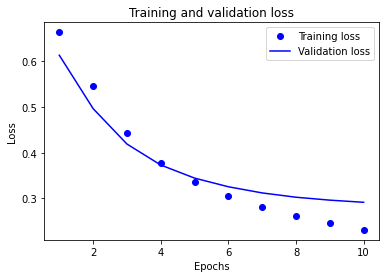

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

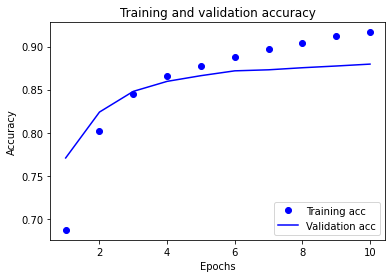

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  1/782 [..............................] - ETA: 3:43 - loss: 0.1761 - accuracy: 0.9375

 11/782 [..............................] - ETA: 4s - loss: 0.2738 - accuracy: 0.8846  

 21/782 [..............................] - ETA: 4s - loss: 0.2878 - accuracy: 0.8800

 31/782 [>.............................] - ETA: 3s - loss: 0.2969 - accuracy: 0.8771

 42/782 [>.............................] - ETA: 3s - loss: 0.3024 - accuracy: 0.8761

 52/782 [>.............................] - ETA: 3s - loss: 0.3032 - accuracy: 0.8765

 62/782 [=>............................] - ETA: 3s - loss: 0.3027 - accuracy: 0.8776

 72/782 [=>............................] - ETA: 3s - loss: 0.3032 - accuracy: 0.8779

 82/782 [==>...........................] - ETA: 3s - loss: 0.3046 - accuracy: 0.8775

 92/782 [==>...........................] - ETA: 3s - loss: 0.3057 - accuracy: 0.8771

102/782 [==>...........................] - ETA: 3s - loss: 0.3069 - accuracy: 0.8767

112/782 [===>..........................] - ETA: 3s - loss: 0.3075 - accuracy: 0.8765

122/782 [===>..........................] - ETA: 3s - loss: 0.3080 - accuracy: 0.8764

132/782 [====>.........................] - ETA: 3s - loss: 0.3083 - accuracy: 0.8765

141/782 [====>.........................] - ETA: 3s - loss: 0.3085 - accuracy: 0.8766

151/782 [====>.........................] - ETA: 3s - loss: 0.3086 - accuracy: 0.8766

161/782 [=====>........................] - ETA: 3s - loss: 0.3088 - accuracy: 0.8767

171/782 [=====>........................] - ETA: 3s - loss: 0.3091 - accuracy: 0.8766

181/782 [=====>........................] - ETA: 3s - loss: 0.3094 - accuracy: 0.8766

191/782 [======>.......................] - ETA: 3s - loss: 0.3095 - accuracy: 0.8766

201/782 [======>.......................] - ETA: 3s - loss: 0.3096 - accuracy: 0.8766

211/782 [=======>......................] - ETA: 2s - loss: 0.3096 - accuracy: 0.8766

222/782 [=======>......................] - ETA: 2s - loss: 0.3097 - accuracy: 0.8765

232/782 [=======>......................] - ETA: 2s - loss: 0.3098 - accuracy: 0.8764

242/782 [========>.....................] - ETA: 2s - loss: 0.3098 - accuracy: 0.8763

251/782 [========>.....................] - ETA: 2s - loss: 0.3099 - accuracy: 0.8762

261/782 [=========>....................] - ETA: 2s - loss: 0.3100 - accuracy: 0.8761

271/782 [=========>....................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8761

280/782 [=========>....................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8760

289/782 [==========>...................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8760

298/782 [==========>...................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8760

307/782 [==========>...................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8760

317/782 [===========>..................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8760

326/782 [===========>..................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8760

335/782 [===========>..................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8759

344/782 [============>.................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8759

353/782 [============>.................] - ETA: 2s - loss: 0.3100 - accuracy: 0.8759

363/782 [============>.................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8759

372/782 [=============>................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8758

381/782 [=============>................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8757

390/782 [=============>................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8757

399/782 [==============>...............] - ETA: 2s - loss: 0.3102 - accuracy: 0.8756

408/782 [==============>...............] - ETA: 2s - loss: 0.3102 - accuracy: 0.8755

417/782 [==============>...............] - ETA: 1s - loss: 0.3103 - accuracy: 0.8754

426/782 [===============>..............] - ETA: 1s - loss: 0.3104 - accuracy: 0.8753

435/782 [===============>..............] - ETA: 1s - loss: 0.3105 - accuracy: 0.8752

444/782 [================>.............] - ETA: 1s - loss: 0.3105 - accuracy: 0.8751

453/782 [================>.............] - ETA: 1s - loss: 0.3106 - accuracy: 0.8750

462/782 [================>.............] - ETA: 1s - loss: 0.3107 - accuracy: 0.8749

471/782 [=================>............] - ETA: 1s - loss: 0.3107 - accuracy: 0.8749

480/782 [=================>............] - ETA: 1s - loss: 0.3108 - accuracy: 0.8748

488/782 [=================>............] - ETA: 1s - loss: 0.3109 - accuracy: 0.8747

497/782 [==================>...........] - ETA: 1s - loss: 0.3109 - accuracy: 0.8747

506/782 [==================>...........] - ETA: 1s - loss: 0.3110 - accuracy: 0.8746

514/782 [==================>...........] - ETA: 1s - loss: 0.3110 - accuracy: 0.8746

523/782 [===================>..........] - ETA: 1s - loss: 0.3111 - accuracy: 0.8745

532/782 [===================>..........] - ETA: 1s - loss: 0.3111 - accuracy: 0.8745

541/782 [===================>..........] - ETA: 1s - loss: 0.3112 - accuracy: 0.8744

550/782 [====================>.........] - ETA: 1s - loss: 0.3112 - accuracy: 0.8744

559/782 [====================>.........] - ETA: 1s - loss: 0.3113 - accuracy: 0.8743

568/782 [====================>.........] - ETA: 1s - loss: 0.3113 - accuracy: 0.8743

577/782 [=====================>........] - ETA: 1s - loss: 0.3114 - accuracy: 0.8743

585/782 [=====================>........] - ETA: 1s - loss: 0.3114 - accuracy: 0.8742

593/782 [=====================>........] - ETA: 1s - loss: 0.3115 - accuracy: 0.8742

602/782 [======================>.......] - ETA: 1s - loss: 0.3115 - accuracy: 0.8742

611/782 [======================>.......] - ETA: 0s - loss: 0.3115 - accuracy: 0.8741

620/782 [======================>.......] - ETA: 0s - loss: 0.3115 - accuracy: 0.8741

629/782 [=======================>......] - ETA: 0s - loss: 0.3116 - accuracy: 0.8741

638/782 [=======================>......] - ETA: 0s - loss: 0.3116 - accuracy: 0.8740

647/782 [=======================>......] - ETA: 0s - loss: 0.3116 - accuracy: 0.8740

655/782 [========================>.....] - ETA: 0s - loss: 0.3116 - accuracy: 0.8740

663/782 [========================>.....] - ETA: 0s - loss: 0.3116 - accuracy: 0.8740

672/782 [========================>.....] - ETA: 0s - loss: 0.3116 - accuracy: 0.8740

680/782 [=========================>....] - ETA: 0s - loss: 0.3116 - accuracy: 0.8740

689/782 [=========================>....] - ETA: 0s - loss: 0.3116 - accuracy: 0.8739

698/782 [=========================>....] - ETA: 0s - loss: 0.3116 - accuracy: 0.8739

707/782 [==========================>...] - ETA: 0s - loss: 0.3116 - accuracy: 0.8739

716/782 [==========================>...] - ETA: 0s - loss: 0.3116 - accuracy: 0.8739

725/782 [==========================>...] - ETA: 0s - loss: 0.3116 - accuracy: 0.8739

734/782 [===========================>..] - ETA: 0s - loss: 0.3116 - accuracy: 0.8739

742/782 [===========================>..] - ETA: 0s - loss: 0.3116 - accuracy: 0.8739

751/782 [===========================>..] - ETA: 0s - loss: 0.3116 - accuracy: 0.8739

760/782 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8739

769/782 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8738

779/782 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8738

782/782 [==============================] - 5s 6ms/step - loss: 0.3115 - accuracy: 0.8738


0.8734800219535828


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6198051 ],
       [0.4428497 ],
       [0.35866177]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multiclass classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multiclass classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

We have prepared a [dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) for you to use containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: to increase the difficulty of the classification problem, we have replaced any occurences of the words Python, CSharp, JavaScript, or Java in the programming questions with the word *blank* (as many questions contain the language they're about). 

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) we have prepreared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications. 

1. Modify the last layer of your model to read `Dense(4)`, as there are now four output classes.

1. When you compile your model, change the loss to `losses.SparseCategoricalCrossentropy`. This is the correct loss function to use for a multiclass classification problem, when the labels for each class are integers (in our case, they can be 0, *1*, *2*, or *3*).

1. Once these changes are complete, you will be able to train a multiclass classifier. 


## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, we recommend reading [this guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
